In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from scipy import stats



In [2]:
# Load the dataset
df = pd.read_csv(
    r'/content/drive/MyDrive/household_power_consumption.txt',
    delimiter=';',
    dtype={
        'Global_active_power': float,
        'Global_reactive_power': float,
        'Voltage': float,
        'Global_intensity': float,
        'Sub_metering_1': float,
        'Sub_metering_2': float,
        'Sub_metering_3': float
    },
    na_values=['?'],
    on_bad_lines='skip'
)
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [3]:
#Data Preprocessing
# Combine date and time columns into a single datetime column with dayfirst=True
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
df = df.set_index('Datetime')
df = df.drop(['Date', 'Time'], axis=1)

In [4]:
# Convert data types to numeric, coerce errors to NaN
df = df.apply(pd.to_numeric, errors='coerce')

In [5]:
# Handle missing values by forward filling
df = df.fillna(method='ffill')

In [6]:
# Ensure the datetime index is sorted and monotonic
df = df.sort_index()
df = df.asfreq('T')  # Assuming the data is recorded every minute

In [7]:
# Exploratory Data Analysis
# Summary statistics
print(df.describe())

       Global_active_power  Global_reactive_power       Voltage  \
count         2.075259e+06           2.075259e+06  2.075259e+06   
mean          1.086168e+00           1.233280e-01  2.408416e+02   
std           1.053172e+00           1.125144e-01  3.235574e+00   
min           7.600000e-02           0.000000e+00  2.232000e+02   
25%           3.080000e-01           4.800000e-02  2.390000e+02   
50%           5.980000e-01           1.000000e-01  2.410200e+02   
75%           1.524000e+00           1.940000e-01  2.428700e+02   
max           1.112200e+01           1.390000e+00  2.541500e+02   

       Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
count      2.075259e+06    2.075259e+06    2.075259e+06    2.075259e+06  
mean       4.604226e+00    1.110995e+00    1.287958e+00    6.416570e+00  
std        4.426775e+00    6.115908e+00    5.786865e+00    8.419505e+00  
min        2.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00  
25%        1.400000e+00   

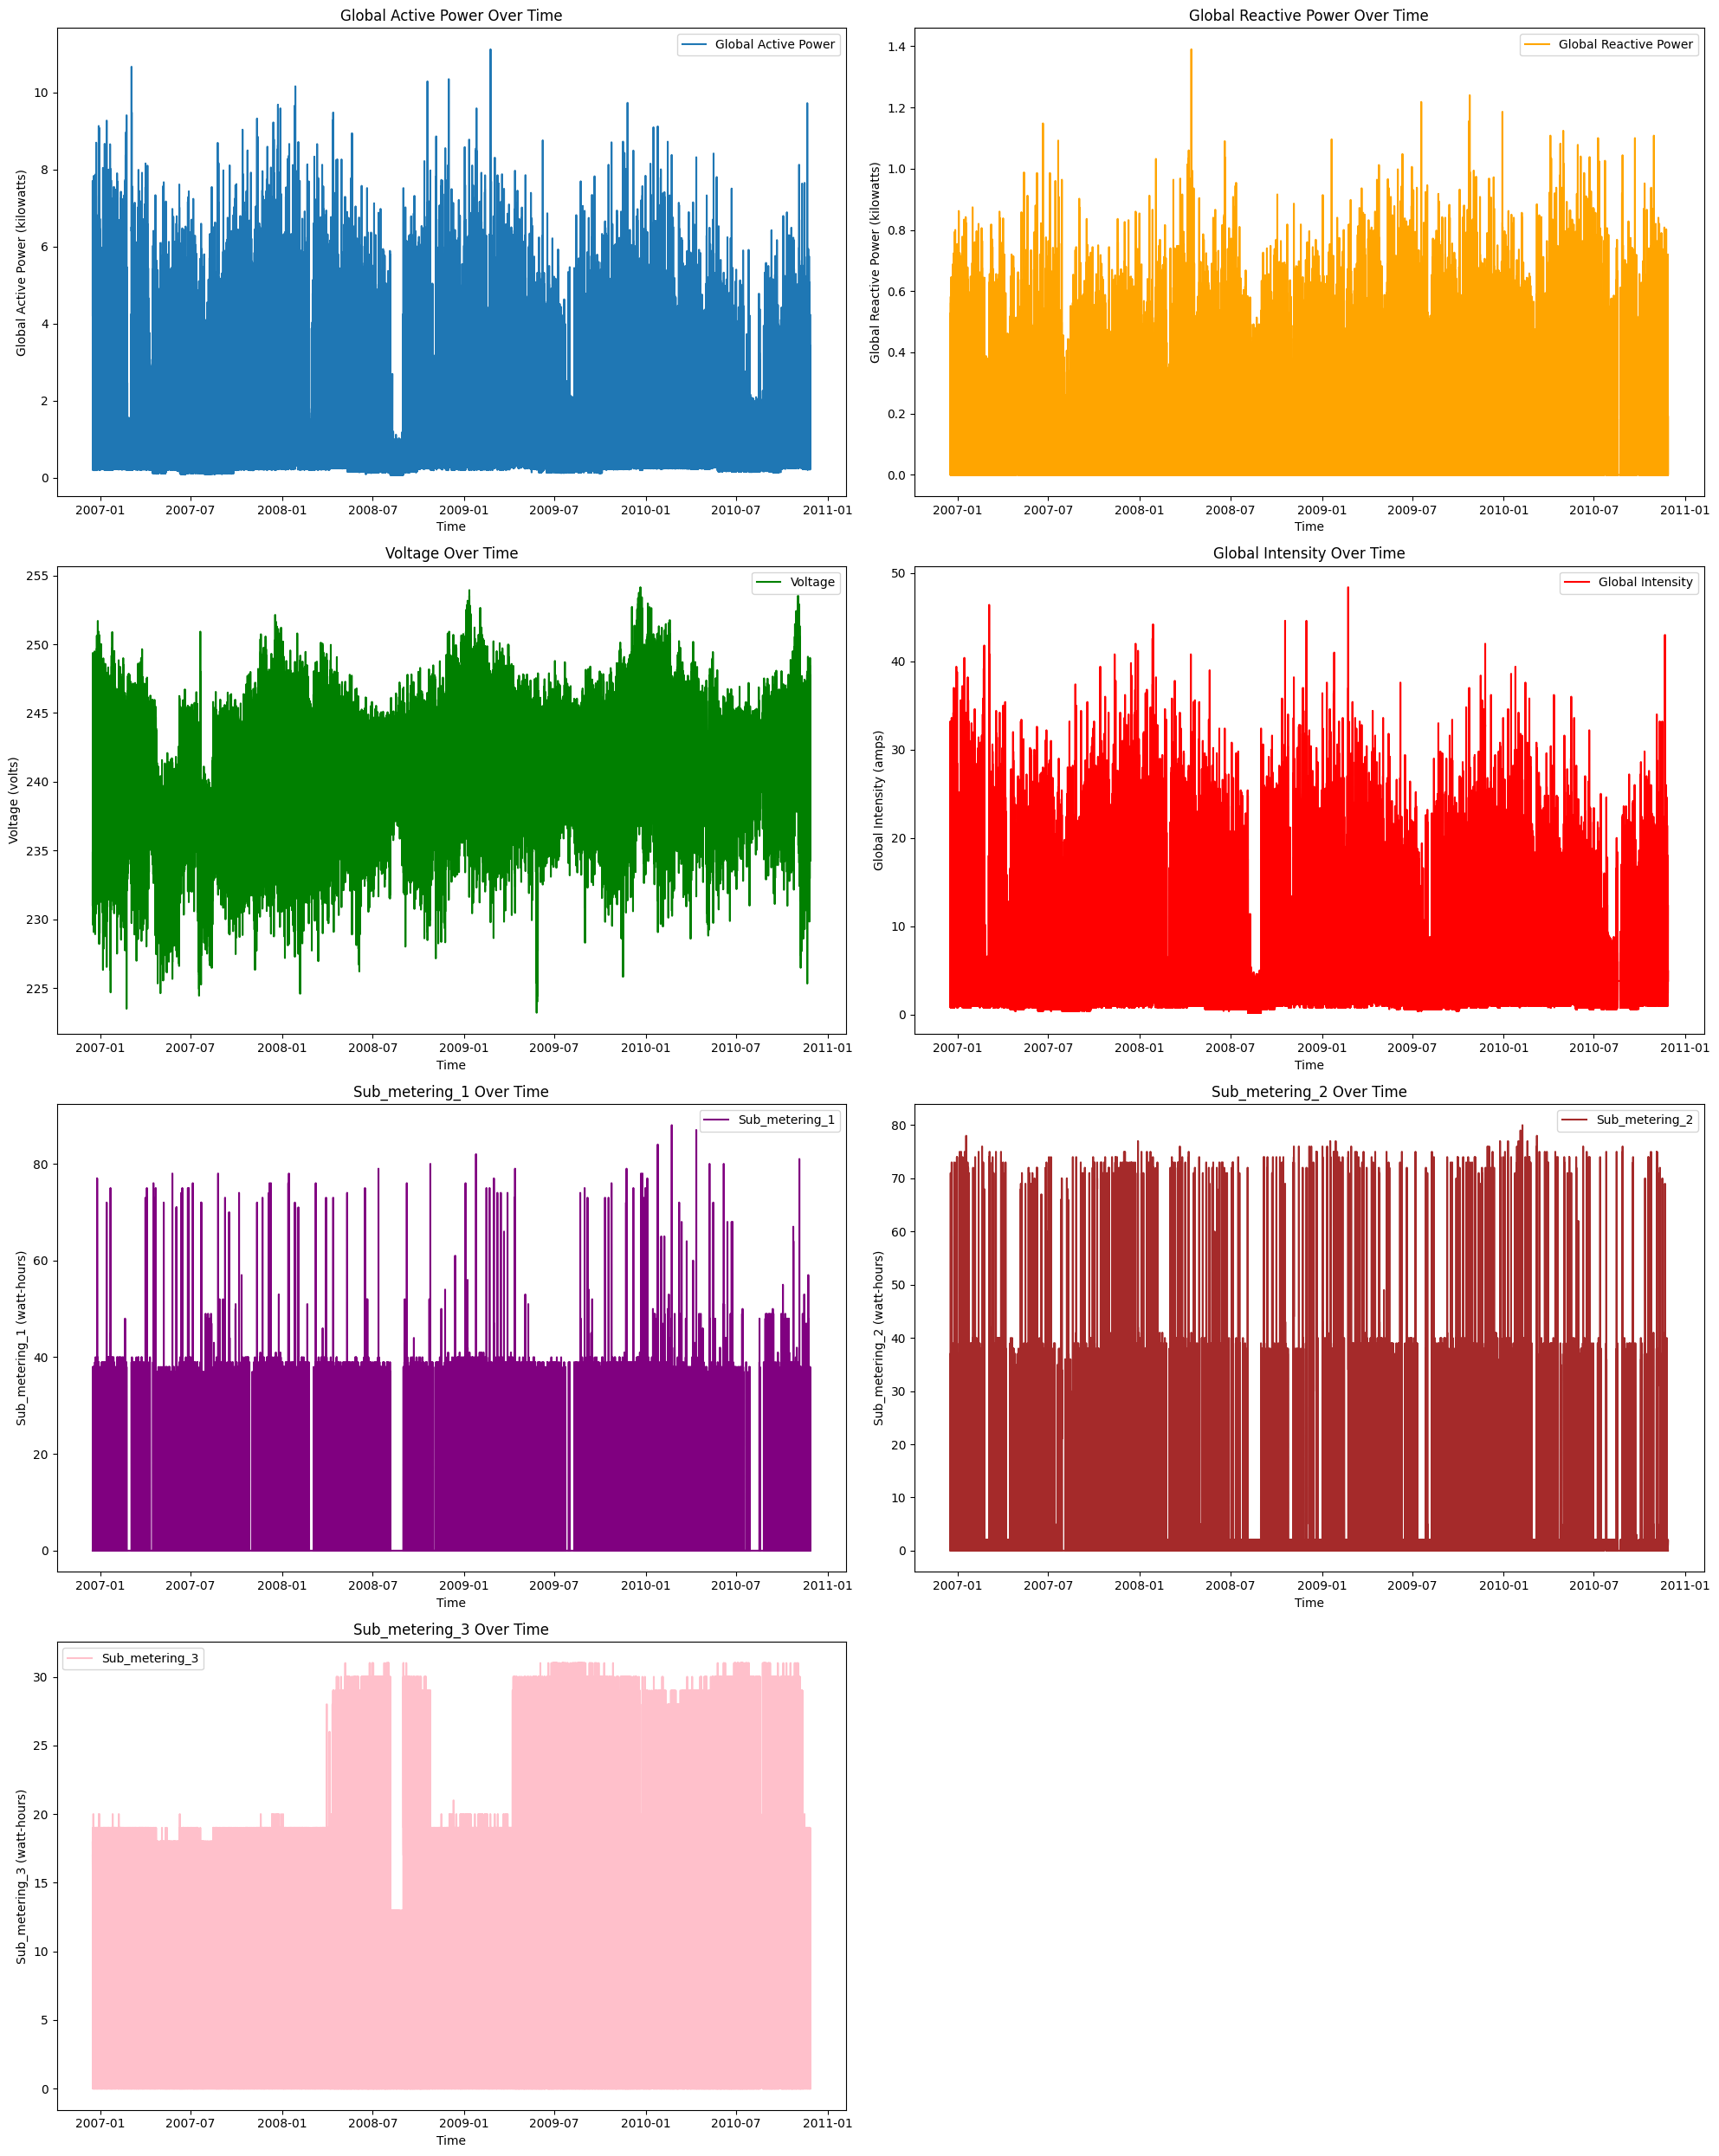

In [8]:
# Plot all features
plt.figure(figsize=(20, 25))

# Global Active Power
plt.subplot(4, 2, 1)
plt.plot(df['Global_active_power'], label='Global Active Power')
plt.title('Global Active Power Over Time')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()

# Global Reactive Power
plt.subplot(4, 2, 2)
plt.plot(df['Global_reactive_power'], label='Global Reactive Power', color='orange')
plt.title('Global Reactive Power Over Time')
plt.xlabel('Time')
plt.ylabel('Global Reactive Power (kilowatts)')
plt.legend()

# Voltage
plt.subplot(4, 2, 3)
plt.plot(df['Voltage'], label='Voltage', color='green')
plt.title('Voltage Over Time')
plt.xlabel('Time')
plt.ylabel('Voltage (volts)')
plt.legend()

# Global Intensity
plt.subplot(4, 2, 4)
plt.plot(df['Global_intensity'], label='Global Intensity', color='red')
plt.title('Global Intensity Over Time')
plt.xlabel('Time')
plt.ylabel('Global Intensity (amps)')
plt.legend()

# Sub_metering_1
plt.subplot(4, 2, 5)
plt.plot(df['Sub_metering_1'], label='Sub_metering_1', color='purple')
plt.title('Sub_metering_1 Over Time')
plt.xlabel('Time')
plt.ylabel('Sub_metering_1 (watt-hours)')
plt.legend()

# Sub_metering_2
plt.subplot(4, 2, 6)
plt.plot(df['Sub_metering_2'], label='Sub_metering_2', color='brown')
plt.title('Sub_metering_2 Over Time')
plt.xlabel('Time')
plt.ylabel('Sub_metering_2 (watt-hours)')
plt.legend()

# Sub_metering_3
plt.subplot(4, 2, 7)
plt.plot(df['Sub_metering_3'], label='Sub_metering_3', color='pink')
plt.title('Sub_metering_3 Over Time')
plt.xlabel('Time')
plt.ylabel('Sub_metering_3 (watt-hours)')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

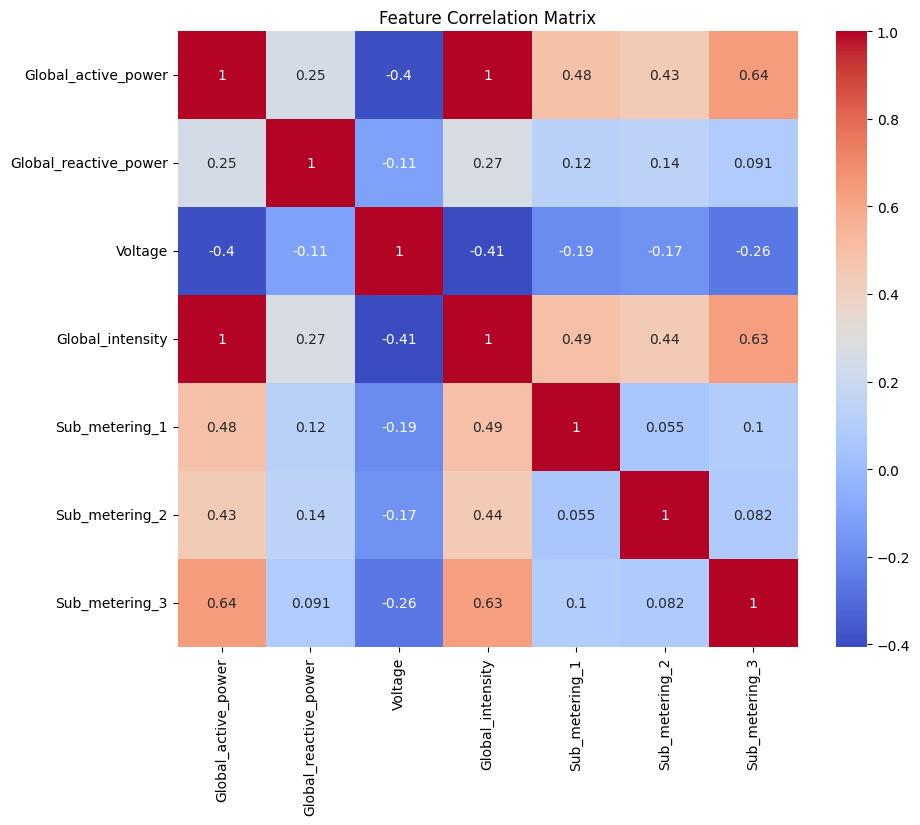

In [9]:
# Correlation analysis
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

**Insights**

**Strong Correlation Between Global Intensity and Global Active Power:** There is a strong positive correlation between 'Global_intensity' and 'Global_active_power', which suggests that as the intensity of electricity usage increases, so does the active power consumption. This is logical since higher electrical intensity (current) typically means higher power usage.

**Moderate Correlation Between Sub_metering_3 and Global Active Power:**             'Sub_metering_3' seems to have a moderate positive correlation with 'Global_active_power'. This could imply that water heater contributes significantly to the overall power consumption in the household.

**Low Correlation Between Voltage and Other Features:** Voltage shows relatively low correlation with most of the other features. This might indicate that voltage fluctuations have little to no direct influence on the overall power consumption patterns in the dataset, or it could be relatively stable, not showing much variability to correlate with other variables.

**Reactive Power Shows Limited Relationship:** 'Global_reactive_power' has a low correlation with 'Global_active_power' and 'Global_intensity'. Reactive power, which is the power that oscillates between the source and load, doesn't increase proportionally with the active power or the intensity of the electricity use, which might indicate a relatively stable or efficient system where reactive power is managed or minimized.

In [10]:
# Feature Engineering
# Create lag features
df['Lag_1'] = df['Global_active_power'].shift(1)
df['Lag_2'] = df['Global_active_power'].shift(2)
df['Lag_3'] = df['Global_active_power'].shift(3)

In [11]:
# Rolling statistics
df['Rolling_mean_3'] = df['Global_active_power'].rolling(window=3).mean()
df['Rolling_std_3'] = df['Global_active_power'].rolling(window=3).std()

In [12]:
# Drop rows with NaN values after feature engineering
df = df.dropna()

In [13]:
df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Lag_1,Lag_2,Lag_3,Rolling_mean_3,Rolling_std_3
Datetime,,,,,,,,,,,,
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,5.374,5.360,4.216,5.374000,0.014000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,5.388,5.374,5.360,4.809333,0.990180
2006-12-16 17:29:00,3.520,0.522,235.02,15.0,0.0,2.0,17.0,3.666,5.388,5.374,4.191333,1.038912
2006-12-16 17:30:00,3.702,0.520,235.09,15.8,0.0,1.0,17.0,3.520,3.666,5.388,3.629333,0.096381
2006-12-16 17:31:00,3.700,0.520,235.22,15.8,0.0,1.0,17.0,3.702,3.520,3.666,3.640667,0.104505
...,...,...,...,...,...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0,0.946,0.942,0.946,0.944667,0.002309
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0,0.946,0.946,0.942,0.945333,0.001155
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0,0.944,0.946,0.946,0.942667,0.004163


In [21]:
# Downsample the data to a daily frequency
df_daily = df.resample('D').mean()

In [22]:
df_daily

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Lag_1,Lag_2,Lag_3,Rolling_mean_3,Rolling_std_3
Datetime,,,,,,,,,,,,
2006-12-16,3.038743,0.085420,236.261501,13.018830,0.000000,1.379135,12.407125,3.045837,3.052443,3.056214,3.045674,0.427473
2006-12-17,2.354486,0.156949,240.087028,9.999028,1.411806,2.907639,9.264583,2.356090,2.357819,2.359528,2.356132,0.358909
2006-12-18,1.530435,0.112356,241.231694,6.421667,0.738194,1.820139,9.734722,1.530325,1.530226,1.530114,1.530329,0.087241
2006-12-19,1.157079,0.104821,241.999313,4.926389,0.582639,5.279167,4.303472,1.157069,1.156960,1.156874,1.157036,0.127598
2006-12-20,1.545658,0.111804,242.308062,6.467361,0.000000,1.838889,9.765972,1.544658,1.543706,1.542563,1.544674,0.078496
...,...,...,...,...,...,...,...,...,...,...,...,...
2010-11-22,1.417733,0.098857,240.197118,6.014167,3.371528,1.465278,7.038889,1.417674,1.417615,1.417553,1.417674,0.097975
2010-11-23,1.095511,0.095451,240.575528,4.674444,1.299306,0.318056,5.285417,1.095556,1.095600,1.095647,1.095556,0.071834
2010-11-24,1.247394,0.091986,240.030965,5.249583,0.761111,1.977778,8.488889,1.247344,1.247354,1.247382,1.247364,0.067616


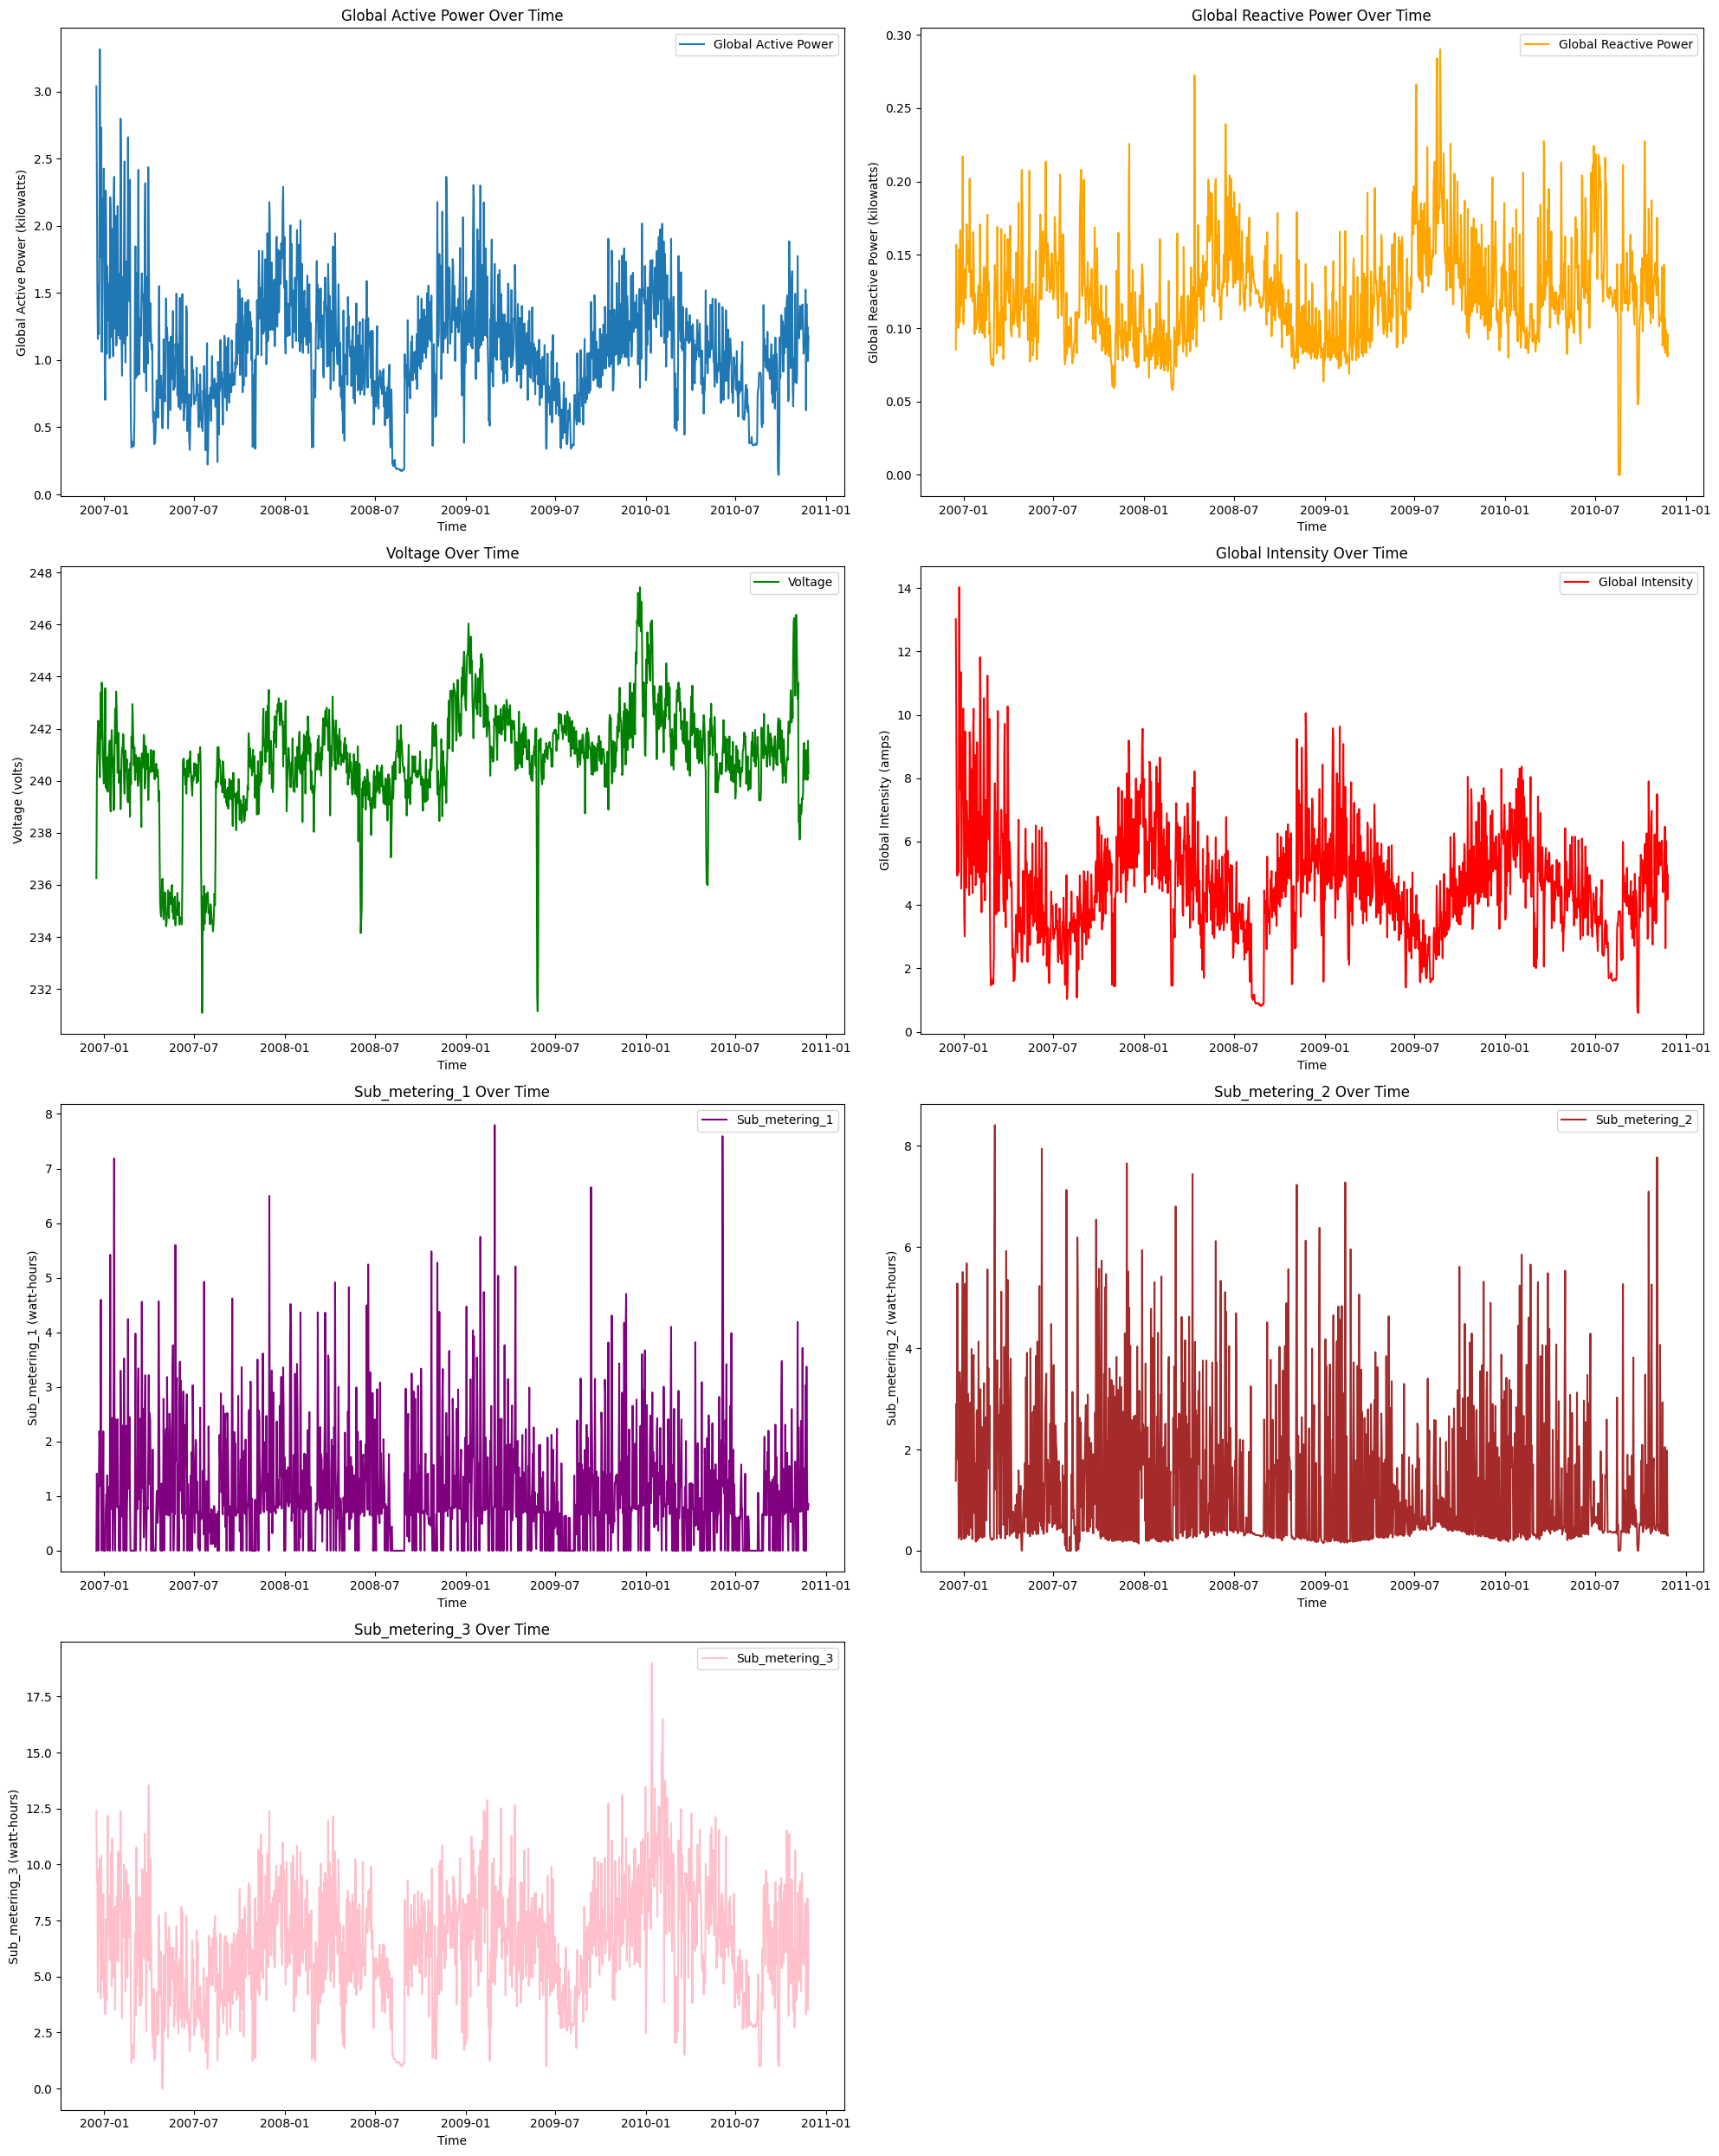

In [23]:
# Plot all features
plt.figure(figsize=(20, 25))

# Global Active Power
plt.subplot(4, 2, 1)
plt.plot(df_daily['Global_active_power'], label='Global Active Power')
plt.title('Global Active Power Over Time')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()

# Global Reactive Power
plt.subplot(4, 2, 2)
plt.plot(df_daily['Global_reactive_power'], label='Global Reactive Power', color='orange')
plt.title('Global Reactive Power Over Time')
plt.xlabel('Time')
plt.ylabel('Global Reactive Power (kilowatts)')
plt.legend()

# Voltage
plt.subplot(4, 2, 3)
plt.plot(df_daily['Voltage'], label='Voltage', color='green')
plt.title('Voltage Over Time')
plt.xlabel('Time')
plt.ylabel('Voltage (volts)')
plt.legend()

# Global Intensity
plt.subplot(4, 2, 4)
plt.plot(df_daily['Global_intensity'], label='Global Intensity', color='red')
plt.title('Global Intensity Over Time')
plt.xlabel('Time')
plt.ylabel('Global Intensity (amps)')
plt.legend()

# Sub_metering_1
plt.subplot(4, 2, 5)
plt.plot(df_daily['Sub_metering_1'], label='Sub_metering_1', color='purple')
plt.title('Sub_metering_1 Over Time')
plt.xlabel('Time')
plt.ylabel('Sub_metering_1 (watt-hours)')
plt.legend()

# Sub_metering_2
plt.subplot(4, 2, 6)
plt.plot(df_daily['Sub_metering_2'], label='Sub_metering_2', color='brown')
plt.title('Sub_metering_2 Over Time')
plt.xlabel('Time')
plt.ylabel('Sub_metering_2 (watt-hours)')
plt.legend()

# Sub_metering_3
plt.subplot(4, 2, 7)
plt.plot(df_daily['Sub_metering_3'], label='Sub_metering_3', color='pink')
plt.title('Sub_metering_3 Over Time')
plt.xlabel('Time')
plt.ylabel('Sub_metering_3 (watt-hours)')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

In [17]:
# Outlier detection using z-score
z_scores = np.abs(stats.zscore(df_daily['Global_active_power']))
outliers = z_scores > 3

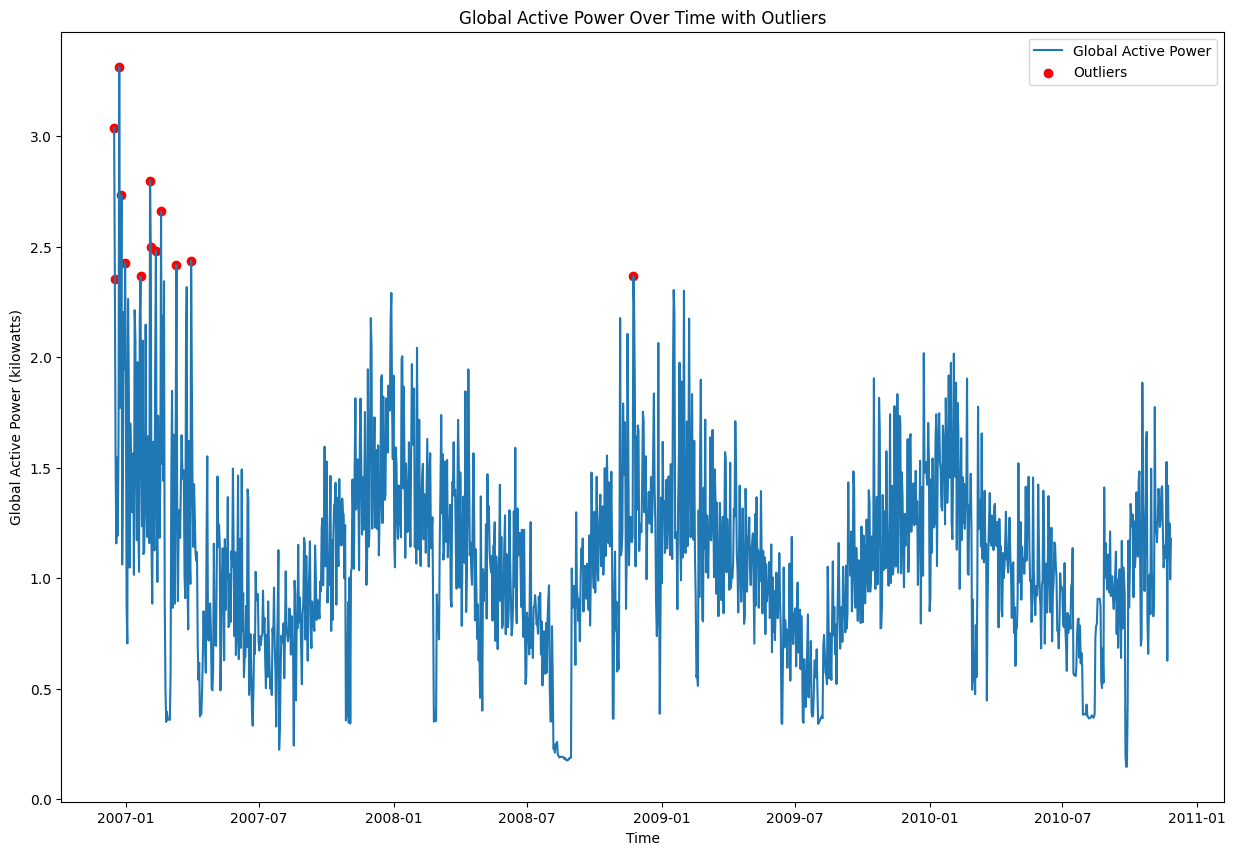

In [18]:
# Plotting the data with outliers
plt.figure(figsize=(15, 10))
plt.plot(df_daily.index, df_daily['Global_active_power'], label='Global Active Power')
plt.scatter(df_daily.index[outliers], df_daily['Global_active_power'][outliers], color='red', label='Outliers')
plt.title('Global Active Power Over Time with Outliers')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.show()

In [19]:
# Remove outliers
df_daily_cleaned = df_daily[~outliers]

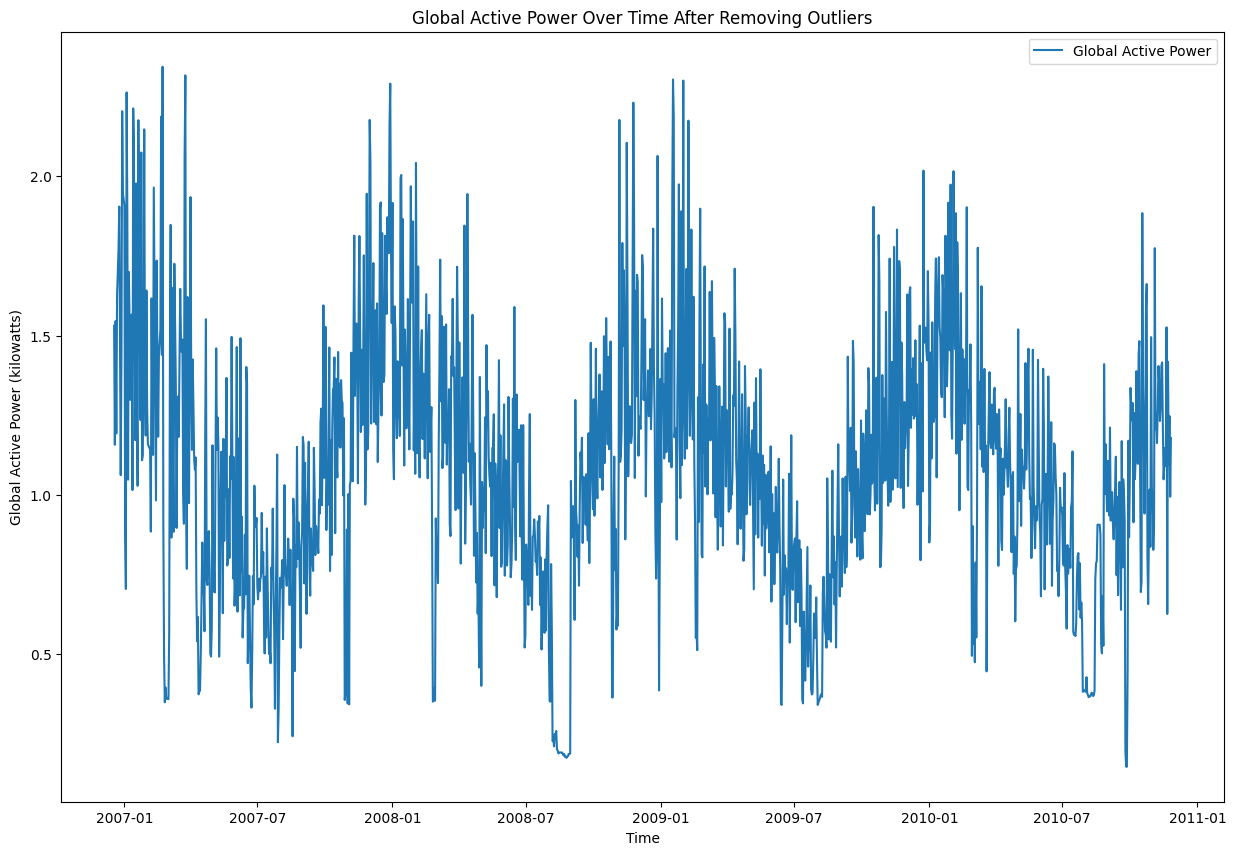

In [20]:
# Plotting the data after removing outliers
plt.figure(figsize=(15, 10))
plt.plot(df_daily_cleaned.index, df_daily_cleaned['Global_active_power'], label='Global Active Power')
plt.title('Global Active Power Over Time After Removing Outliers')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.show()

**Insights**

**Potential Seasonality:** The variations in power usage could indicate seasonality. For example, higher power usage might occur during colder months due to heating or during hotter months due to air conditioning.

**Regular Variation:** There is a clear pattern of regular variation, which could indicate a daily cycle of power usage, with peaks possibly corresponding to morning or evening when energy usage is typically higher.

**Consistent Baseline:** A consistent baseline level of power consumption is apparent, indicating a steady usage of electricity that could be associated with always-on devices or a minimum set of appliances regularly used in the household.

**Data Gaps:** There are some vertical gaps in the data where there appears to be no consumption recorded, or possibly missing data.

**Intermittent Drops:** There are intermittent drops in power consumption, including a significant drop around late October. This could indicate occasional periods when less electricity is used, which may be due to the residents being away, certain appliances not being used, or possible data collection issues.

**Recovery After Drops:** After the notable drop in power consumption, the levels appear to recover back to the usual range. This suggests that the drop was a temporary event rather than a permanent change in consumption habits or system measurement changes.

In [27]:
# Split the data into training and testing sets
train_size = int(len(df_daily_cleaned) * 0.8)
train_data, test_data = df_daily_cleaned[:train_size], df_daily_cleaned[train_size:]

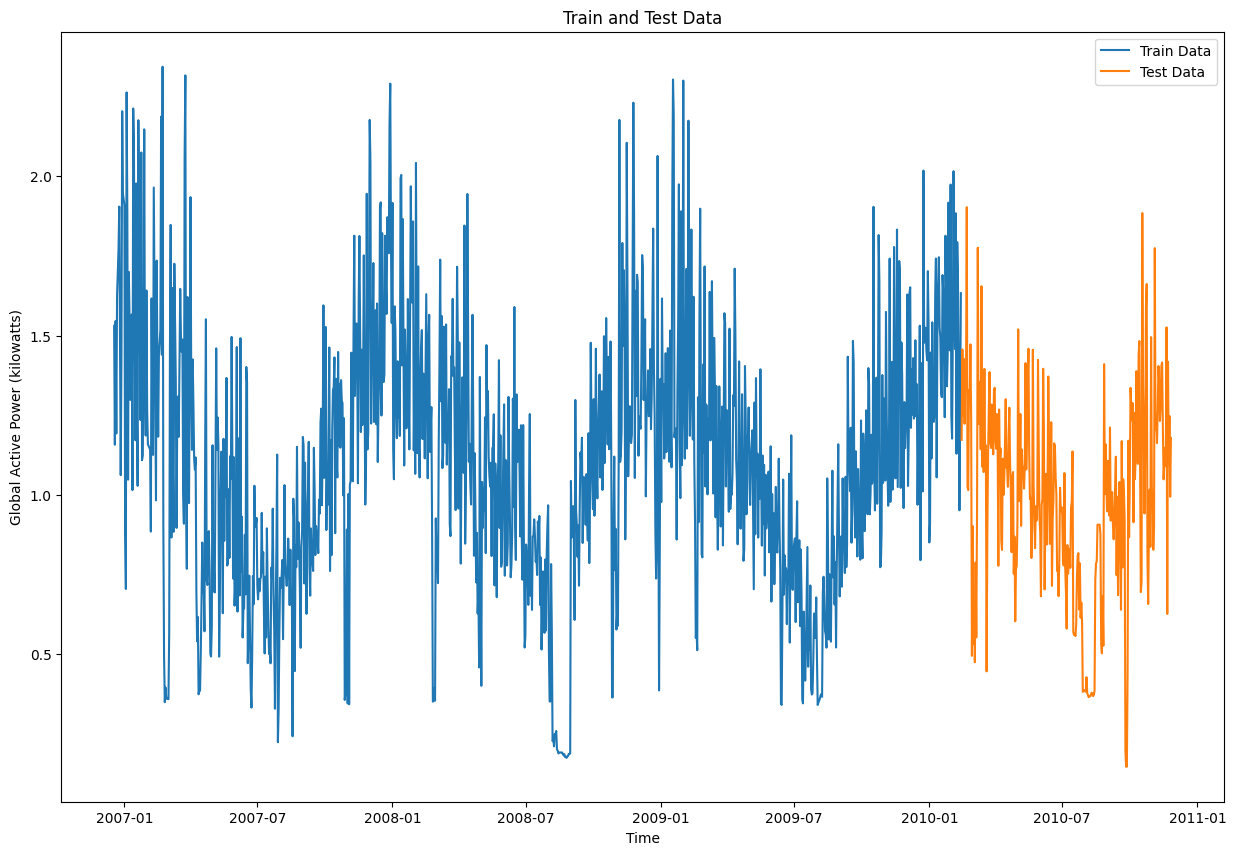

In [28]:
# Plot training and testing data
plt.figure(figsize=(15, 10))
plt.plot(train_data.index, train_data['Global_active_power'], label='Train Data')
plt.plot(test_data.index, test_data['Global_active_power'], label='Test Data')
plt.title('Train and Test Data')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.show()

In [39]:
# Normalize the target variable
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[['Global_active_power']])
test_scaled = scaler.transform(test_data[['Global_active_power']])


In [40]:
#Prepare the data for LSTM model
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 7  # using a week for time steps
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, y_test = create_dataset(test_scaled, time_step)

In [41]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [42]:
# Define function to create LSTM model
def create_model(optimizer='adam', units=50, dropout_rate=0.2, input_shape=(time_step, 1)):
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [43]:

# Hyperparameter tuning
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'units': [50, 100],
    'dropout_rate': [0.2, 0.3],
    'batch_size': [32, 64],
    'epochs': [50, 100]
}

best_mape = np.inf
best_params = None
best_model = None

for optimizer in param_grid['optimizer']:
    for units in param_grid['units']:
        for dropout_rate in param_grid['dropout_rate']:
            for batch_size in param_grid['batch_size']:
                for epochs in param_grid['epochs']:
                    model = create_model(optimizer=optimizer, units=units, dropout_rate=dropout_rate, input_shape=(time_step, 1))
                    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
                    y_pred = model.predict(X_test)
                    y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
                    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
                    mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
                    if mape < best_mape:
                        best_mape = mape
                        best_params = {
                            'optimizer': optimizer,
                            'units': units,
                            'dropout_rate': dropout_rate,
                            'batch_size': batch_size,
                            'epochs': epochs
                        }
                        best_model = model

print(f'Best MAPE: {best_mape}')
print(f'Best Parameters: {best_params}')

9/9 [==============================] - 1s 7ms/step
Best MAPE: 0.22392027558880326
Best Parameters: {'optimizer': 'adam', 'units': 100, 'dropout_rate': 0.3, 'batch_size': 32, 'epochs': 100}


In [44]:
# Make predictions with the best model
train_predict = best_model.predict(X_train)
test_predict = best_model.predict(X_test)

9/9 [==============================] - 0s 6ms/step


In [45]:
# Inverse transform to get actual values
train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

In [46]:
# Evaluate the best model
train_mape = mean_absolute_percentage_error(y_train_actual, train_predict)
test_mape = mean_absolute_percentage_error(y_test_actual, test_predict)
train_accuracy = 100 - train_mape
test_accuracy = 100 - test_mape
print(f'Train MAPE: {train_mape}')
print(f'Test MAPE: {test_mape}')
print(f'Train Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

Train MAPE: 0.2373370648947102
Test MAPE: 0.22392027558880326
Train Accuracy: 99.76266293510528
Test Accuracy: 99.77607972441119


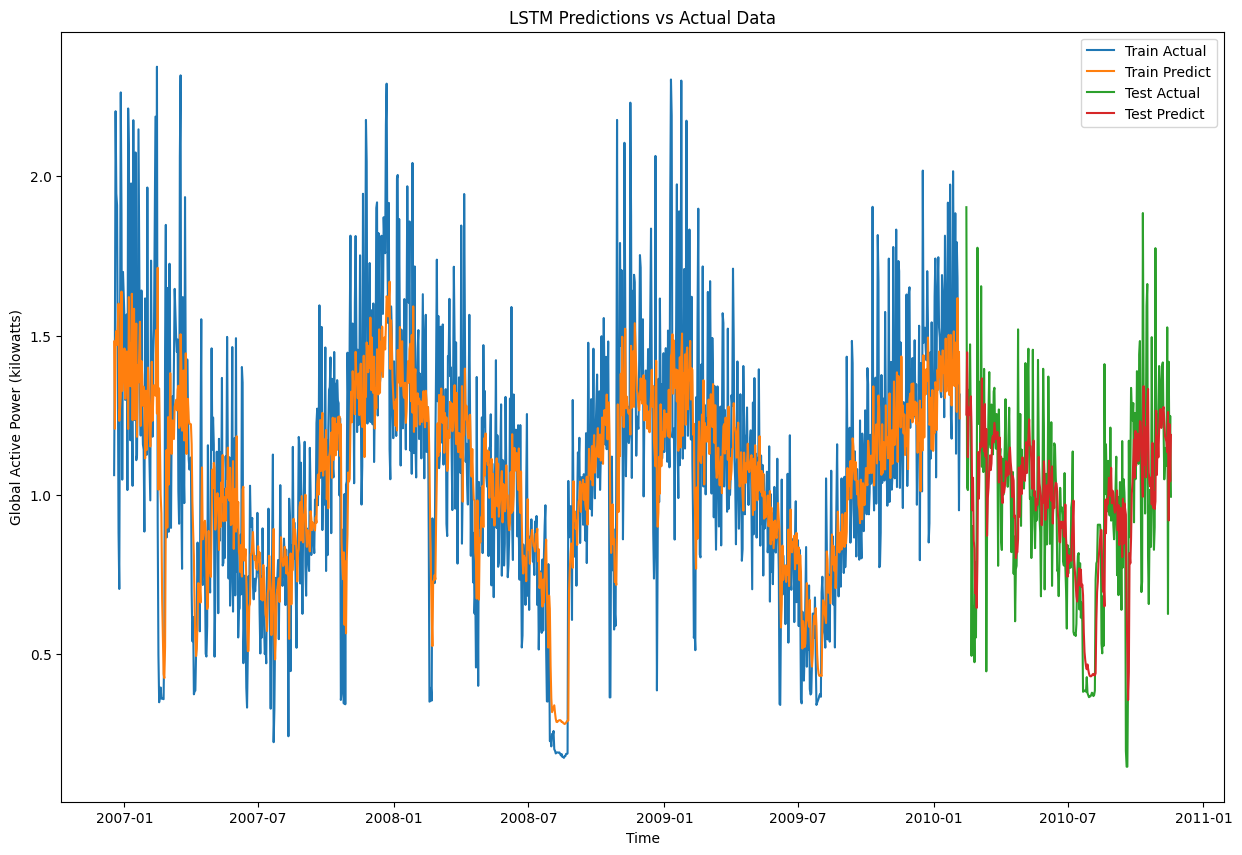

In [48]:
# Plot predictions
plt.figure(figsize=(15, 10))

# Plot training actual and predictions
plt.plot(df_daily_cleaned.index[:len(y_train_actual)], y_train_actual, label='Train Actual')
plt.plot(df_daily_cleaned.index[:len(y_train_actual)], train_predict, label='Train Predict')

# Plot testing actual and predictions
plt.plot(df_daily_cleaned.index[len(y_train_actual) + time_step + 1 : len(y_train_actual) + time_step + 1 + len(y_test_actual)], y_test_actual, label='Test Actual')
plt.plot(df_daily_cleaned.index[len(y_train_actual) + time_step + 1 : len(y_train_actual) + time_step + 1 + len(y_test_actual)], test_predict, label='Test Predict')

plt.title('LSTM Predictions vs Actual Data')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.show()